In [1]:
%pylab inline
import pandas as pd
from sklearn import model_selection, metrics, neighbors, preprocessing, dummy

Populating the interactive namespace from numpy and matplotlib


In [2]:
data=pd.read_csv("winequality-red.csv", sep=";")

In [3]:
data.describe(include="all")

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [4]:
data.columns.size

12

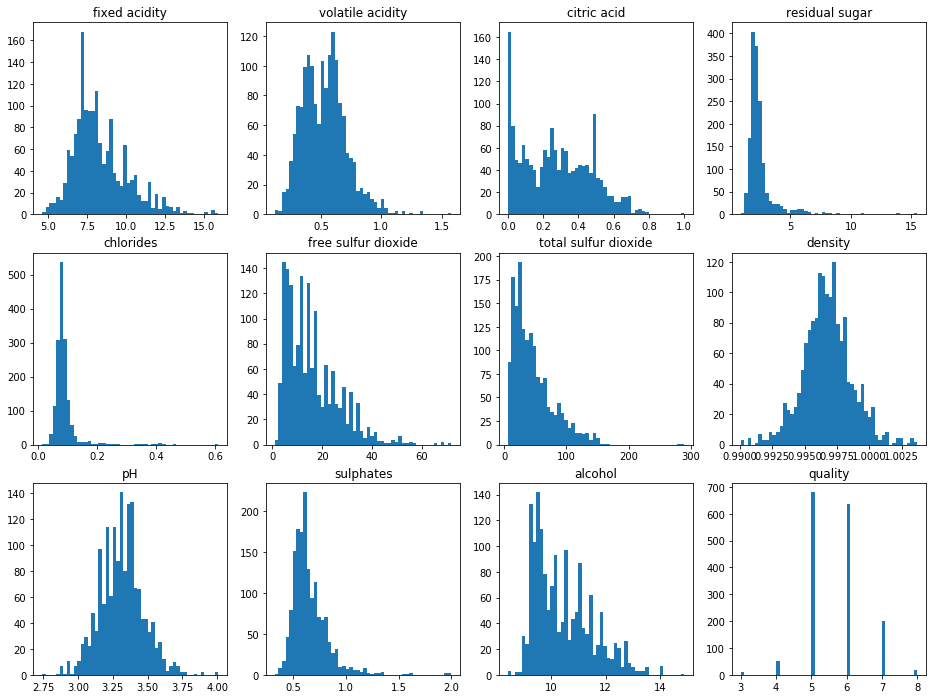

In [5]:
fig=plt.figure(figsize=(16,12))
for c in range(data.columns.size):
    ax=fig.add_subplot(3,4,c+1)
    ax.hist(data.iloc[:,c], bins=50)
    ax.set_title(data.columns[c])

## data preparation

In [6]:
scaler=preprocessing.StandardScaler()
X = pd.DataFrame(scaler.fit_transform(data.iloc[:,:-1]))
X.columns = data.iloc[:,:-1].columns
y=data.iloc[:,-1]

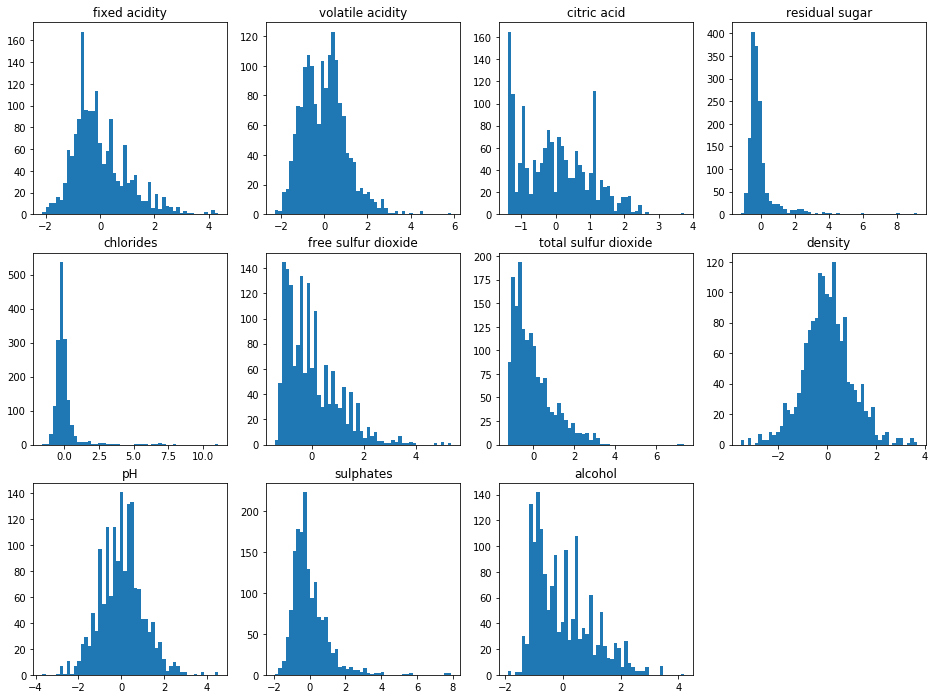

In [7]:
fig=plt.figure(figsize=(16,12))
for c in range(X.columns.size):
    ax=fig.add_subplot(3,4,c+1)
    ax.hist(X.iloc[:,c], bins=50)
    ax.set_title(X.columns[c])

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y,test_size=0.2, stratify=y)

## Self implementation of cross validation & hyper-parameters search

In [9]:
def myGridSearchCV(X_, y_, estimator, param_grid, cv):
    param_names=list(param_grid.keys())
    param_names.extend(["average_mean_squared_error","average_R2_score"])
    tmpRes=[]
    skf=model_selection.StratifiedKFold(cv)
    for param in model_selection.ParameterGrid(param_grid):
        estimator.set_params(**param)
        mean_squared_error=[]
        R2_score=[]
        for train_index,test_index in skf.split(X_,y_):
            XtrainGS, XtestGS = X_.iloc[train_index], X_.iloc[test_index]
            ytrainGS, ytestGS = y_.iloc[train_index], y_.iloc[test_index]
            estimator.fit(XtrainGS, ytrainGS)
            ytestGS_predicted=estimator.predict(XtestGS)
            mean_squared_error.append(((ytestGS-ytestGS_predicted)**2).sum()/ytestGS.size)
            R2_score.append(metrics.r2_score(ytestGS, ytestGS_predicted))
        param.update({"average_mean_squared_error":np.mean(mean_squared_error)})
        param.update({"average_R2_score":np.mean(R2_score)})
        tmpRes.append(param)
    cv_results_=pd.DataFrame(tmpRes, columns=param_names)
    return cv_results_

In [10]:
#example
results_GS = myGridSearchCV(X_train, y_train, neighbors.KNeighborsRegressor(n_jobs=-1), 
               {"n_neighbors":range(3,20)},cv=5)

Text(0, 0.5, 'average mean squared error')

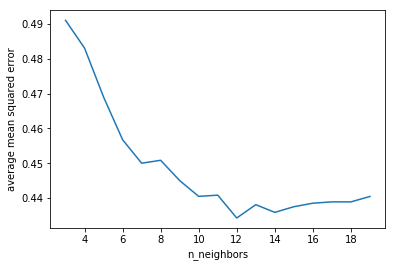

In [23]:
plt.plot(results_GS.n_neighbors,results_GS.average_mean_squared_error)
plt.xlabel("n_neighbors")
plt.ylabel("average mean squared error")

Text(0, 0.5, 'average R2 score')

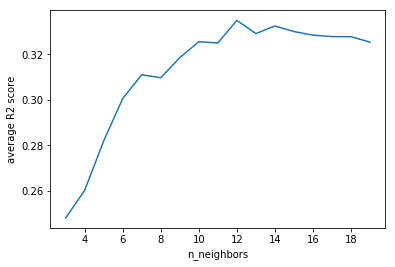

In [24]:
plt.plot(results_GS.n_neighbors,results_GS.average_R2_score)
plt.xlabel("n_neighbors")
plt.ylabel("average R2 score")

In [25]:
#best set
results_GS.loc[results_GS.idxmin()["average_mean_squared_error"]]

n_neighbors                   12.000000
average_mean_squared_error     0.434308
average_R2_score               0.335028
Name: 9, dtype: float64

## Best k-NN model

In [13]:
regressor=neighbors.KNeighborsRegressor(n_neighbors=15)
regressor.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=15, p=2,
          weights='uniform')

In [14]:
y_predicted=regressor.predict(X_test)

In [15]:
mse=metrics.mean_squared_error(y_test, y_predicted)
print("MSE best k-NN =",mse)
R2=metrics.r2_score(y_test, y_predicted)
print("R2 best k-NN =",R2)

MSE best k-NN = 0.44683333333333336
R2 best k-NN = 0.3075287043202777


## Comparison with naive approaches

In [16]:
y_predicted_random=np.random.randint(np.min(y_test),np.max(y_test),y_test.size)

In [17]:
mse_random=metrics.mean_squared_error(y_test, y_predicted_random)
print("MSE random value prediction =",mse_random)
R2_random=metrics.r2_score(y_test, y_predicted_random)
print("R2 random value prediction =",R2_random)

MSE random value prediction = 3.028125
R2 random value prediction = -3.692778013196924


In [18]:
dummy_regressor=dummy.DummyRegressor()
dummy_regressor.fit(X_train, y_train)
y_predicted_mean=dummy_regressor.predict(X_test)

In [19]:
mse_mean=metrics.mean_squared_error(y_test, y_predicted_mean)
print("MSE mean value prediction =",mse_mean)
R2_mean=metrics.r2_score(y_test, y_predicted_mean)
print("R2 mean value prediction =",R2_mean)

MSE mean value prediction = 0.6453090375225954
R2 mean value prediction = -5.51704448477075e-05


## Plot of the 3 approaches

In [20]:
def sizes(y):
    sizes_dict={}
    for (yt, yp) in zip(y_test, y):
        if (yt, yp) in sizes_dict:
            sizes_dict[(yt, yp)]+=1
        else:
            sizes_dict[(yt, yp)]=1
    return sizes_dict

In [21]:
sizes_predicted=sizes(y_predicted)
sizes_predicted_random=sizes(y_predicted_random)
sizes_predicted_mean=sizes(y_predicted_mean)

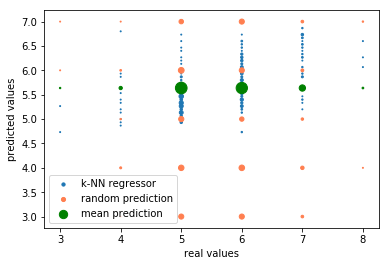

In [22]:
plt.scatter([k[0] for k in sizes_predicted.keys()],
            [k[1] for k in sizes_predicted.keys()],
            [sizes_predicted[k] for k in sizes_predicted.keys()], 
            label="k-NN regressor")
plt.scatter([k[0] for k in sizes_predicted_random.keys()],
            [k[1] for k in sizes_predicted_random.keys()],
            [sizes_predicted_random[k] for k in sizes_predicted_random.keys()], 
            color='coral', label="random prediction")
plt.scatter([k[0] for k in sizes_predicted_mean.keys()],
            [k[1] for k in sizes_predicted_mean.keys()],
            [sizes_predicted_mean[k] for k in sizes_predicted_mean.keys()], 
            color='green', label="mean prediction")
plt.xlabel("real values")
plt.ylabel("predicted values")
plt.legend()

## Youpi! Le k-NN apporte bien une amélioration sur la prédiction de la qualité d'un vin comparativement aux approches naives!